# Crime & Economy Project (in python)

In this project I look for a relationship between economic data and crime rates. 

I obtained statistics for various industries at the county level from the BLS. I also found the number of arrests and charge for a variety of crimes at the county level. These datasets span 2010 to 2016 in two year intervals.

After cleaning the data I will test out a variety of statistical tools and methods to try and find meaningful relationships and models in the data. 

In [1]:
# Project
import os
print(os.getcwd())
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt
import random as random
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.formula.api as smf
import timeit
# Imports functions from seperate notebook
%run Functions.ipynb

C:\Users\Matt\Downloads\Project


Here I load in the data and spit out some summary statistics on the structure of the data.

In [2]:
# Reading in Data
start_time = timeit.default_timer()
# Keys to extract formatted State and County names
key = pd.read_excel('fips_codes_website.xls')   # Counties and major cities
key00 = pd.read_csv('FIPS_countycodes.txt',delimiter=',')  # Counties only
key00['GU Name'] = key00['GU Name'].str[:-7]  # Slice 'county' from names
# Crime
crime2010 = pd.read_csv('33523-0001-crimedata2010.txt',delimiter='\t')
crime2012 = pd.read_csv('35019-0001-crimedata2012.txt',delimiter='\t')
crime2014 = pd.read_csv('36399-0001-crimedata2014.txt',delimiter='\t')
crime2016 = pd.read_csv('37059-0001-crimedata2016.txt',delimiter='\t')
# Enumployment & Wages
#test_wages_18 = pd.read_excel('allhlcn183.xlsx',sheet_name='US_St_Cn_MSA')
wage_unemp2018 = pd.read_csv('allhlcn183wage_unemp2018.txt',delimiter='\t',dtype={'St':str})
wage_unemp2016 = pd.read_csv('allhlcn163wage_unemp2016.txt',delimiter='\t',dtype={'St':str})
wage_unemp2014 = pd.read_csv('allhlcn143wage_unemp2014.txt',delimiter='\t',dtype={'St':str})
wage_unemp2012 = pd.read_csv('allhlcn123wage_unemp2012.txt',delimiter='\t',dtype={'St':str})
wage_unemp2010 = pd.read_csv('allhlcn103wage_unemp2010.txt',delimiter='\t',dtype={'St':str})

print("2014 crime:",crime2014.shape,"// key:",key.shape)
print('2018 Wages:',wage_unemp2018.shape)
x = ((crime2014.shape[0])*(crime2014.shape[1]))*4 + ((wage_unemp2018.shape[0])*(wage_unemp2018.shape[1]))*5 + (key00.shape[0])*key00.shape[1]
print(x,'unique datapoints in all datasets')
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

2014 crime: (3177, 56) // key: (41787, 7)
2018 Wages: (62724, 21)
7313843 unique datapoints in all datasets
9.216 run time


In [3]:
# Data Cleaning #
start_time = timeit.default_timer()
# Yearly cleaned databases
crime10 = crime_cleaner(crime2010)
crime12 = crime_cleaner(crime2012)
crime14 = crime_cleaner(crime2014)
crime16 = crime_cleaner(crime2016)
cols = list(crime14.columns.values) # Grab columns
# Cleaned Wage Data
economic10 = wage_cleaner(wage_unemp2010) # Returns county level data sets
economic12 = wage_cleaner(wage_unemp2012)
economic14 = wage_cleaner(wage_unemp2014)
economic16 = wage_cleaner(wage_unemp2016)
economic18 = wage_cleaner(wage_unemp2018)
economic18['Industry'] = economic18['Industry'].str[1:] # Remove first space in 2018 industry codes

# Combined crime and economic dataframes and rearrange columns
db2010 = crime10.merge(economic10,left_on=['State Abbreviation','GU Name'],right_on=['State Abbreviation','GU Name'])
cols = db2010.columns.tolist()  # Code to rearrange columns
cols = ['Year']+cols[:-14]+cols[-10:]
db2010 = db2010[cols]
db2012 = crime12.merge(economic12,left_on=['State Abbreviation','GU Name'],right_on=['State Abbreviation','GU Name'])
db2012 = db2012[cols]
db2014 = crime14.merge(economic14,left_on=['State Abbreviation','GU Name'],right_on=['State Abbreviation','GU Name'])
db2014 = db2014[cols]
db2016 = crime16.merge(economic16,left_on=['State Abbreviation','GU Name'],right_on=['State Abbreviation','GU Name'])
db2016 = db2016[cols]
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

11.24 run time


Here I generate a sample dataset of randomly selected counties and all associated data. 

It is worth noting that this can be computationally expensive and that cell run times take about 0.1 seconds per county in the sample. 

(e.g. a sample of 400 counties will take ~40 seconds to generate in the cell below)

In [4]:
# Selects X Random counties and stores them as a dictionary by count // Key = MI, County
start_time = timeit.default_timer()
samp_db = {}
for n in range(100):
    r = random.randint(0,len(crime12))
    x = crime12['State Abbreviation'].iloc[r] # Pull State Abreviation
    y = crime12['GU Name'].iloc[r]  # Pull analogous county name
    z = x+', '+y # Format name for dictionary key
    agg = test_search(y,x) # Return criminal and economic data
    samp_db[z] = agg  # Add data to empty dictionary
keys = list(samp_db.keys())
print(len(samp_db))
print(samp_db.keys())
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

98
dict_keys(['NM, Chaves', 'OR, Jackson', 'MI, Otsego', 'VA, Washington', 'IN, Steuben', 'IL, Stark', 'KY, Bracken', 'GA, Paulding', 'PA, Erie', 'TX, Sterling', 'GA, Dawson', 'ND, Bowman', 'NV, Mineral', 'CO, Eagle', 'CO, Clear Creek', 'FL, Hendry', 'OH, Crawford', 'NJ, Hunterdon', 'TX, Lampasas', 'TX, Bell', 'AL, Monroe', 'TX, Ellis', 'VA, Buena Vis', 'MO, Daviess', 'TN, Robertson', 'MT, Sweet Grass', 'IA, Audubon', 'NY, Westchester', 'KY, Nicholas', 'ND, Mercer', 'OK, Ellis', 'IA, Iowa', 'NC, Avery', 'IL, Fayette', 'PA, Centre', 'NC, Perquimans', 'OK, Harper', 'IL, Morgan', 'PA, Cameron', 'MN, Beltrami', 'OH, Lake', 'MN, Kittson', 'OH, Putnam', 'SC, Saluda', 'IL, Kendall', 'VA, Shenandoah', 'LA, Calcasieu', 'AR, Lawrence', 'MO, Nodaway', 'MO, Cass', 'WV, Mingo', 'LA, Union', 'WI, Marquette', 'CA, Calaveras', 'NE, Hooker', 'WV, Kanawha', 'SC, Sumter', 'IA, Taylor', 'CO, San Juan', 'MO, Mississippi', 'CA, San Joaquin', 'LA, Morehouse', 'WV, Clay', 'NC, Chatham', 'IL, Randolph', 'NE, N

In [5]:
# Select 5 biggest industries in sample
start_time = timeit.default_timer()
industry = big_industry_bot(samp_db)
print('5 Largest Industries in sample:\n',industry)
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

5 Largest Industries in sample:
 ['Goods-producing', 'Construction', 'Service-providing', 'Trade, transportation, and utilities', 'Financial activities']
0.044 run time


In [6]:
start_time = timeit.default_timer()
# Initialize sample to new variable for trouble shooting // preserve OG sample data
bedrock = samp_db

# start base data frame -- create new dataframe, still need to account for various industries
new_world = pd.DataFrame()

for a in keys:
    for b in industry[:]:
        x = bedrock[a].loc[bedrock[a]['Industry'] == b] #
        new_world = new_world.append(x)
        
new_world = new_world.reset_index()  # reset index
new_world = new_world.drop('index',axis=1)  # drop index column
cols = new_world.columns.tolist() # rearrange columns
cols = cols[:3]+cols[-9:]+cols[3:48]
new_world = new_world[cols]

elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')
new_world.head(10)

3.726 run time


Year State Abbreviation GU Name           Industry  Establishment Count  \
0  2010                 NM  Chaves    Goods-producing                  337   
1  2012                 NM  Chaves    Goods-producing                  325   
2  2014                 NM  Chaves    Goods-producing                  311   
3  2016                 NM  Chaves    Goods-producing                  312   
4  2010                 NM  Chaves       Construction                  159   
5  2012                 NM  Chaves       Construction                  148   
6  2014                 NM  Chaves       Construction                  133   
7  2016                 NM  Chaves       Construction                  126   
8  2010                 NM  Chaves  Service-providing                 1257   
9  2012                 NM  Chaves  Service-providing                 1246   

  July Employment August Employment  September Employment  \
0           3,551             3,551                  3612   
1           3,708             3,718                  3666   
2           3,733             3,701                  3644   
3           3,575             3,549                  3527   
4             901               901                   917   
5             933               944                   929   
6             884               877                   858   
7             835               848                   837   
8          13,396            13,461                 13366   
9          12,983            12,971                 12934   

  Total Quarterly Wages  Average Weekly Wage   ...     OFAGFAM  DUI  LIQUOR  \
0            31,283,048                  674   ...          32  291     406   
1            34,056,467                  709   ...          19  261     315   
2            35,583,831                  741   ...          28  192     154   
3            35,902,325                  778   ...          26  233      96   
4             8,081,960                  686   ...          32  291     406   
5             8,589,641                  706   ...          19  261     315   
6             7,561,423                  666   ...          28  192     154   
7             7,849,217                  719   ...          26  233      96   
8            92,407,122                  530   ...          32  291     406   
9            90,930,117                  540   ...          19  261     315   

   DRUNK  DISORDR  VAGRANT  ALLOTHR  SUSPICN  CURFEW  RUNAWAY  
0      0      434       32     2267        2       0        0  
1      0      429        0     1773        3       0        0  
2      0      256        0     4548        0       0        0  
3      0      239        0     5405        0       0        0  
4      0      434       32     2267        2       0        0  
5      0      429        0     1773        3       0        0  
6      0      256        0     4548        0       0        0  
7      0      239        0     5405        0       0        0  
8      0      434       32     2267        2       0        0  
9      0      429        0     1773        3       0        0  

[10 rows x 57 columns]

Due to inconsistencies in the data it is important that we double check that there is the same number of data entries for each industry we want to observe. If we have an uneven database, we need to draw a new sample. 

In [7]:
start_time = timeit.default_timer()
crimes = cols[12:]
# Create a list of all industry data entrys
l1 = []
for a in new_world['Industry']:
    l1.append(a)
print('Count of target industries in sample \n\n MUST ALL BE SAME\n')
# Find count of each indutry in sample
l2 = []
for a in industry:
    #print(a,'//',l1.count(a)) # Print out count of each industry in data frame
    l2.append(l1.count(a))

c = l2[0]
for a in l2[1:]:
    if a == c:
        print('Check')
    else:
        print('Failed Industry Count Check')

elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

Count of target industries in sample 

 MUST ALL BE SAME

Check
Check
Check
Check
0.003 run time


In [8]:
start_time = timeit.default_timer()
# Create final data frame that accounts for metrics across industries
samp_dic = {}
stat = ['Establishment Count','Average Weekly Wage','August Employment']

for s in stat:
    for n in industry:
        samp_dic[n+' '+s] = test_func(new_world,keys,s,n)

for a in crimes:
    samp_dic[a] = test_funk(bedrock,a)
    
finaldb = pd.DataFrame(data=samp_dic)

print(samp_dic.keys(),'\n\n')
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')
finaldb.head(10)

dict_keys(['Goods-producing Establishment Count', 'Construction Establishment Count', 'Service-providing Establishment Count', 'Trade, transportation, and utilities Establishment Count', 'Financial activities Establishment Count', 'Goods-producing Average Weekly Wage', 'Construction Average Weekly Wage', 'Service-providing Average Weekly Wage', 'Trade, transportation, and utilities Average Weekly Wage', 'Financial activities Average Weekly Wage', 'Goods-producing August Employment', 'Construction August Employment', 'Service-providing August Employment', 'Trade, transportation, and utilities August Employment', 'Financial activities August Employment', 'MURDER', 'P1TOT', 'P1VLNT', 'P1PRPTY', 'RAPE', 'ROBBERY', 'AGASSLT', 'BURGLRY', 'LARCENY', 'MVTHEFT', 'ARSON', 'OTHASLT', 'FRGYCNT', 'FRAUD', 'EMBEZL', 'STLNPRP', 'VANDLSM', 'WEAPONS', 'COMVICE', 'SEXOFF', 'DRUGTOT', 'DRGSALE', 'COCSALE', 'MJSALE', 'SYNSALE', 'OTHSALE', 'DRGPOSS', 'COCPOSS', 'MJPOSS', 'SYNPOSS', 'OTHPOSS', 'GAMBLE', 'BO

Goods-producing Establishment Count  Construction Establishment Count  \
0                                  337                               159   
1                                  325                               148   
2                                  311                               133   
3                                  312                               126   
4                                 1095                               633   
5                                 1105                               626   
6                                 1131                               643   
7                                 1231                               716   
8                                  165                                93   
9                                  147                                81   

   Service-providing Establishment Count  \
0                                   1257   
1                                   1246   
2                                   1285   
3                                   1338   
4                                   5050   
5                                   5242   
6                                   5397   
7                                   5657   
8                                    551   
9                                    525   

   Trade, transportation, and utilities Establishment Count  \
0                                                355          
1                                                350          
2                                                357          
3                                                351          
4                                               1238          
5                                               1295          
6                                               1307          
7                                               1292          
8                                                174          
9                                                166          

   Financial activities Establishment Count  \
0                                       169   
1                                       168   
2                                       168   
3                                       160   
4                                       616   
5                                       613   
6                                       612   
7                                       641   
8                                        58   
9                                        60   

   Goods-producing Average Weekly Wage  Construction Average Weekly Wage  \
0                                  674                               686   
1                                  709                               706   
2                                  741                               666   
3                                  778                               719   
4                                  711                               761   
5                                  726                               787   
6                                  799                               835   
7                                  865                               890   
8                                  751                               652   
9                                  813                               688   

   Service-providing Average Weekly Wage  \
0                                    530   
1                                    540   
2                                    571   
3                                    576   
4                                    610   
5                                    657   
6                                    685   
7                                    744   
8                                    539   
9                                    545   

   Trade, transportation, and utilities Average Weekly Wage  \
0                                                551          
1                    

In [9]:
# Check to ensure that data frame is made of only int64 values
start_time = timeit.default_timer()
x = finaldb.dtypes
x = pd.DataFrame(data=x)
x = x.transpose()
# Create list of column names that are not int64
target = []
for a in x:
    if x[a][0] == 'object':
        b = str(x[a])[:-15]
        b = b[18:]
        target.append(b)
# Convert string columns to interger columns
for a in target:
        finaldb[a] = finaldb[a].str.replace(',','')
        finaldb[a] = finaldb[a].astype(int)
        #print(finaldb[a])
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

0.03 run time


# Statistical Analysis

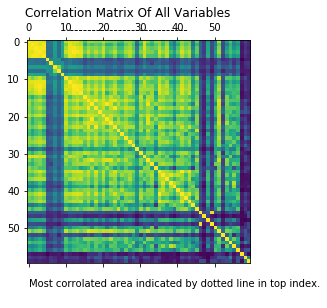


10 HIGHEST total correlations:


Trade, transportation, and utilities August Employment      P1TOT  \
0                                          43.260239       43.153015   

     P1PRPTY  Service-providing August Employment    DRUGTOT    ROBBERY  \
0  42.646961                             42.34685  42.258802  42.213146   

   Trade, transportation, and utilities Establishment Count  \
0                                          42.192854          

   Goods-producing August Employment    LARCENY    DRGPOSS  
0                          41.976406  41.904413  41.762974

In [10]:
corrdb = finaldb.corr().abs().sum()
corrdbl = pd.DataFrame(data=corrdb).nlargest(10,0).transpose()
corrdbs = pd.DataFrame(data=corrdb).nsmallest(10,0).transpose()
# Creates a correlation matrix of all variables
plt.matshow(finaldb.corr())
plt.suptitle('Correlation Matrix Of All Variables\n')
plt.title('           ---------------------------',loc='left')
plt.annotate('Most corrolated area indicated by dotted line in top index.\n',(0,0),(0,69))
plt.show()
cols = finaldb.columns.tolist()
print('\n10 HIGHEST total correlations:')
corrdbl

In [23]:
print('--Index of most correlated variables(highest to lowest)--')
for i in corrdbl:
    print(i+' Index number:',finaldb.columns.get_loc(i))

--Index of most correlated variables(highest to lowest)--
Trade, transportation, and utilities August Employment Index number: 13
P1TOT Index number: 16
P1PRPTY Index number: 18
Service-providing August Employment Index number: 12
DRUGTOT Index number: 35
ROBBERY Index number: 20
Trade, transportation, and utilities Establishment Count Index number: 3
Goods-producing August Employment Index number: 10
LARCENY Index number: 23
DRGPOSS Index number: 41


**REGRESSION**

In [24]:
x = finaldb[list(finaldb.columns.values[:15])]  # Select columns to use as independant vars
y = finaldb['DUI']  # Set y variable

model = sm.OLS(y, x.astype(float)).fit()
predictions = model.predict(x) # make the predictions by the model

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    DUI   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     384.1
Date:                Thu, 23 May 2019   Prob (F-statistic):          2.40e-217
Time:                        12:37:09   Log-Likelihood:                -2520.0
No. Observations:                 391   AIC:                             5070.
Df Residuals:                     376   BIC:                             5130.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------